### EYE FOR BLIND: An Image Captioning Project

- This notebook is the capstone project for the EPGP program by Upgrad and IIITB. 

- The project, titled "Eye for Blind," focuses on generating descriptive captions for images.

- The implementation is roughly based on the paper: **"Show, Attend and Tell: Neural Image Caption Generation with Visual Attention"**.

### Quick Tech Review

#### 1. Architecture

* **Encoder**: Inception V3 (top removed) -> extract *mixed7* grid features -> Dense layer projects to common embedding space.
* **Decoder**: LSTM + **Bahdanau Attention** -> attends to image regions each step to predict next word.
* **Attention math**: alignment scores -> weighted context vector -> fed to LSTM with word embed.

#### 2. Training Tricks

* **Feature caching**: save pre-extracted `.npy` files to skip repeat CNN passes.
* **Mixed-precision (AMP)**: `mixed_float16` for speed & lower VRAM.
* **Custom `train_step` (@tf.function)**: fast graph execution, easy add-ons.
* **Gradient clipping**: `tf.clip_by_global_norm` to tame exploding grads.
* **Attention regularizer**: penalty if weights <> 1.0.

#### 3. Data-to-Text Bridging

* **Scheduled sampling**: linearly swap teacher forcing -> self-feeding to cut exposure bias.
* **Beam search (inference)**: keeps top-*k* partial captions + length penalty for balanced outputs.

#### 4. Training Management

* **Early stopping**: halt when val BLEU-4 stalls (patience configurable).

#### 5. Evaluation & Explainability

* **Metrics**: BLEU-1/2/3/4 + timing stats.
* **Attention heat-maps**: visualize focus per generated word.
* **EDA helpers**: caption length histos, word freq, sample previews.
* **Optional TTS**: gTTS turns captions into audio.

---

Result: a lean, cache-efficient, attention-guided captioner that’s fast to train, interpretable, and yields high-quality descriptions.


In [41]:
import os, re, time, random, collections, tqdm, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from gtts import gTTS
from IPython.display import Audio, display

###  CONFIGURATION

In [42]:
CONFIG: Dict[str, object] = {
    # Directory containing image files
    'image_dir': '/home/flickr8k/Images',
    
    # Path to the captions file
    'caption_file': '/home/flickr8k/captions.txt',
    
    # Directory to cache extracted image features
    'feature_cache_dir': '/home/flickr8k/cache',
    
    # Number of examples to use (None means use all)
    'num_examples': None,
    
    # Maximum length of captions (in tokens)
    'max_caption_length': 50,
    
    # Minimum word frequency for vocabulary pruning
    'min_word_frequency': 5,

    # Embedding dimension for the model
    'embedding_dim': 256,
    
    # Number of units in LSTM
    'units': 512,
    
    # Dropout rate for the decoder
    'decoder_dropout': 0.5,

    # Learning rate for the optimizer
    'learning_rate': 5e-5,
    
    # Number of training epochs
    'epochs': 30,
    
    # Batch size for training
    'batch_size': 64,

    # Buffer size for shuffling the dataset
    'buffer_size': 10000,
    
    # Early stopping patience
    'patience': 8,
    
    # Path to save model checkpoints
    'checkpoint_path': './checkpoints/flickr8k_fresh_run',
    
    # Enable mixed precision training for faster computation
    'mixed_precision': True,

    # Regularization weight for attention alignment
    'attention_reg_lambda': 0.5,
    
    # Gradient clipping value to prevent exploding gradients
    'grad_clip_value': 5.0,
    
    # Maximum probability for scheduled sampling
    'scheduled_sampling_max_prob': 0.2,
    
    # Random seed for reproducibility
    'seed': 42,
}

###  ENV SETUP

In [43]:
# Set random seeds for reproducibility
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# Enable mixed precision training if configured
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("[AMP] mixed_float16 policy active")
else:
    print("[AMP] disabled - using float32 throughout")

# Configure GPU memory growth to prevent memory allocation issues
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using GPU: {physical_devices[0].name} | batch={CONFIG['batch_size']}")
else:
    print("GPU not found - fallback to CPU")

# Set AUTOTUNE for optimizing data pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

[AMP] mixed_float16 policy active
Using GPU: /physical_device:GPU:0 | batch=64


###  DATA LOADING AND PREPROCESSING

In [44]:
class DataProcessor:
    """
    Handles loading, preprocessing, and splitting of image-caption data for image captioning.
    - Loads captions and images, checks for missing files.
    - Preprocesses captions (lowercase, remove non-alpha, add tokens).
    - Builds tokenizer and prunes vocab by min_word_frequency.
    - Splits data into train/val/test and pairs images with padded caption sequences.
    - Supports mapping to cached image features.
    - Can display random samples with captions for sanity check.
    """

    def __init__(self, config):
        # Store config and initialize all data structures
        self.config = config
        self.tokenizer: Optional[Tokenizer] = None
        self.img_to_cap_map: Dict[str, List[str]] = collections.defaultdict(list)
        self.image_paths: List[str] = []
        self.all_captions: List[str] = []
        self.train_data: List[Tuple[str, List[int]]] = []
        self.val_data: List[Tuple[str, List[int]]] = []
        self.test_data: List[Tuple[str, List[int]]] = []
        self.max_caption_length = 0
        self.vocab_size = 0
        self.num_steps_per_epoch = 0

    def load_and_preprocess_data(self):
        """
        Loads captions from CSV, checks image existence, preprocesses captions,
        builds tokenizer, prunes vocab, and computes max caption length.
        """
        print("Loading and preprocessing captions...")
        df = pd.read_csv(self.config['caption_file'], engine='python')
        df['image'] = df['image'].str.strip()
        df['caption'] = df['caption'].str.strip()

        temp_img_to_cap_map = collections.defaultdict(list)
        all_unique_img_names_from_csv = df['image'].unique()

        print(f"Checking {len(all_unique_img_names_from_csv)} unique image files from CSV...")
        found_images_count = 0

        existing_image_files = set(os.listdir(self.config['image_dir']))

        for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="Validating images & processing captions"):
            img_name = row['image']
            caption = row['caption']

            if img_name in existing_image_files:
                temp_img_to_cap_map[img_name].append(self.preprocess_text(caption))
                if img_name not in self.img_to_cap_map:
                    found_images_count += 1
                self.img_to_cap_map[img_name] = temp_img_to_cap_map[img_name]

        if found_images_count < len(all_unique_img_names_from_csv):
            print(f"Warning: {len(all_unique_img_names_from_csv) - found_images_count} images mentioned in CSV were not found in {self.config['image_dir']}. They have been discarded.")

        self.image_paths = sorted(list(self.img_to_cap_map.keys()))

        if self.config['num_examples']:
            if len(self.image_paths) > self.config['num_examples']:
                self.image_paths = random.sample(self.image_paths, self.config['num_examples'])
                self.img_to_cap_map = {img: self.img_to_cap_map[img] for img in self.image_paths}
                print(f"Using a subset of {len(self.image_paths)} images due to 'num_examples' config.")

        self.all_captions = []
        for img_name in self.image_paths:
            self.all_captions.extend(self.img_to_cap_map[img_name])

        print(f"Total valid images (with captions): {len(self.image_paths)}")
        print(f"Total valid captions: {len(self.all_captions)}")

        # Build tokenizer and prune vocab
        self.tokenizer = Tokenizer(num_words=None, oov_token="<unk>",
                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                   lower=True)
        self.tokenizer.fit_on_texts(self.all_captions)

        word_counts = collections.Counter(word for caption in self.all_captions for word in caption.split())
        filtered_word_index = {
            word: index for word, index in self.tokenizer.word_index.items()
            if word_counts[word] >= self.config['min_word_frequency'] or word in ['<pad>', '<start>', '<end>', '<unk>']
        }
        self.tokenizer.word_index = filtered_word_index
        self.tokenizer.index_word = {v: k for k, v in filtered_word_index.items()}

        # Ensure special tokens are correctly in word_index and index_word with proper mapping
        special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
        next_index = len(self.tokenizer.word_index) + 1
        for token in special_tokens:
            if token not in self.tokenizer.word_index:
                self.tokenizer.word_index[token] = next_index
                self.tokenizer.index_word[next_index] = token
                next_index += 1

        # This is where vocab_size is correctly determined based on the processed data.
        self.vocab_size = len(self.tokenizer.word_index) + 1 # +1 for 0-indexing
        print(f"Vocabulary size after pruning (min_word_frequency={self.config['min_word_frequency']}): {self.vocab_size}")

        all_seqs = self.tokenizer.texts_to_sequences(self.all_captions)
        self.max_caption_length = max(len(s) for s in all_seqs)
        # Update CONFIG with the dynamically determined max_caption_length
        self.config['max_caption_length'] = self.max_caption_length
        print(f"Max caption length: {self.max_caption_length}")
        
    def preprocess_text(self, caption: str) -> str:
        """
        Lowercases, removes non-alpha chars, trims, and adds <start>/<end> tokens.
        """
        caption = caption.lower()
        caption = re.sub(r"[^a-z ]", "", caption)
        caption = re.sub(r'\s+', ' ', caption).strip()
        caption = '<start> ' + caption + ' <end>'
        return caption

    def create_dataset_splits(self, train_ratio=0.8, val_ratio=0.1):
        """
        Shuffles and splits image paths into train/val/test, then pairs with captions.
        """
        random.shuffle(self.image_paths)
        num_images = len(self.image_paths)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)

        train_image_paths = self.image_paths[:num_train]
        val_image_paths = self.image_paths[num_train:num_train + num_val]
        test_image_paths = self.image_paths[num_train + num_val:]

        print(f"Train images: {len(train_image_paths)}, Val images: {len(val_image_paths)}, Test images: {len(test_image_paths)}")

        self.train_data = self._create_pairs(train_image_paths)
        self.val_data = self._create_pairs(val_image_paths)
        self.test_data = self._create_pairs(test_image_paths)

        print(f"Train pairs: {len(self.train_data)}, Val pairs: {len(self.val_data)}, Test pairs: {len(self.test_data)}")

        self.num_steps_per_epoch = len(self.train_data) // self.config['batch_size']

    def _create_pairs(self, image_names: List[str]) -> List[Tuple[str, List[int]]]:
        """
        For each image, pairs it with all its captions (as padded int sequences).
        """
        pairs = []
        for img_name in image_names:
            full_img_path = os.path.join(self.config['image_dir'], img_name)
            for caption in self.img_to_cap_map[img_name]:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                padded_seq = pad_sequences([seq], maxlen=self.max_caption_length, padding='post')[0]
                pairs.append((full_img_path, list(padded_seq)))
        return pairs

    def get_data_with_cached_features(self, image_name_to_cached_path_map: Dict[str, str]) -> Tuple[List, List, List]:
        """
        Replaces image paths with cached feature paths if available, for all splits.
        Only keeps pairs where cached features exist.
        """
        def _reconstruct_list(data_list):
            reconstructed = []
            for original_img_path, caption_ids in data_list:
                basename = os.path.basename(original_img_path)
                cached_path = image_name_to_cached_path_map.get(basename)
                if cached_path and os.path.exists(cached_path): # Added check if cached file actually exists
                    reconstructed.append((original_img_path, cached_path, caption_ids))
            return reconstructed

        final_train = _reconstruct_list(self.train_data)
        final_val = _reconstruct_list(self.val_data)
        final_test = _reconstruct_list(self.test_data)

        print(f"Adjusted train pairs (after feature caching check): {len(final_train)}")
        print(f"Adjusted val pairs (after feature caching check): {len(final_val)}")
        print(f"Adjusted test pairs (after feature caching check): {len(final_test)}")
        
        return final_train, final_val, final_test

    def display_samples(self, num_samples: int = 5):
        """
        Randomly picks a few images and displays them with their ground truth captions.
        Useful for sanity check of data loading and preprocessing.
        """
        print(f"\n--- Displaying {num_samples} Random Dataset Samples ---")

        # Get a list of all image paths that have associated captions
        available_image_paths = sorted(list(self.img_to_cap_map.keys()))

        if not available_image_paths:
            print("No image paths with captions available to display.")
            return

        # Randomly select a few image names
        samples_to_display = random.sample(available_image_paths, min(num_samples, len(available_image_paths)))

        for i, img_name in enumerate(samples_to_display):
            full_image_path = os.path.join(self.config['image_dir'], img_name)

            if not os.path.exists(full_image_path):
                print(f"Warning: Image file not found for {img_name} at {full_image_path}. Skipping.")
                continue

            print(f"\n--- Sample {i+1}/{num_samples} ---")
            print(f"Image Name: {img_name}")

            try:
                img = Image.open(full_image_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.title(f"Image: {img_name}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error loading or displaying image {img_name}: {e}")
                continue

            gt_captions = self.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    # Clean up <start> and <end> tokens for display
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

    def plot_caption_length_histogram(self):
        caption_lengths = [len(s.split()) for s in self.all_captions]
        plt.figure(figsize=(10, 6))
        plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 2), edgecolor='black')
        plt.title('Histogram of Caption Lengths')
        plt.xlabel('Caption Length (words)')
        plt.ylabel('Number of Captions')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    def plot_top_words(self, top_n: int = 20):
        words = [word for caption in self.all_captions for word in caption.split() 
                if word not in ['<start>', '<end>', '<pad>', '<unk>']]
        word_counts = collections.Counter(words)
        top_words = word_counts.most_common(top_n)
        words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Frequency', y='Word', hue='Word', data=words_df, palette='viridis', legend=False)
        plt.title(f'Top {top_n} Most Frequent Words (excluding special tokens)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.show()

    def plot_sample_images_with_caption(self, num_images: int = 6):
        selected_images = random.sample(self.image_paths, min(num_images, len(self.image_paths)))
        
        fig, axes = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns for 6 images
        axes = axes.flatten()

        for i, img_name in enumerate(selected_images):
            full_path = os.path.join(self.config['image_dir'], img_name)
            if not os.path.exists(full_path):
                print(f"Warning: Image {img_name} not found. Skipping.")
                continue

            try:
                img = Image.open(full_path)
                ax = axes[i]
                ax.imshow(img)
                ax.set_title(f"{img_name}\nCap: {self.img_to_cap_map[img_name][0].replace('<start>','').replace('<end>','').strip()}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                axes[i].set_title("Image Load Error")
                axes[i].axis('off')
                continue

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

###  IMAGE FEATURE EXTRACTION (CACHE FEATURES)

In [45]:
class ImageFeatureExtractor(Model):
    """
    Extracts image features using a pre-trained InceptionV3 model.
    - Resizes images to target size and preprocesses them for InceptionV3.
    - Extracts features from the 'mixed7' layer of the model.
    """

    def __init__(self, target_size=(299, 299)):
        """
        Initializes the feature extractor with InceptionV3.
        - Freezes the model to prevent training.
        - Extracts features from the 'mixed7' layer.
        """
        super().__init__()
        self.target_size = target_size
        self.inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        self.inception_v3.trainable = False  # Freeze the model
        self.feature_extractor = Model(inputs=self.inception_v3.input,
                                       outputs=self.inception_v3.get_layer('mixed7').output)

    @tf.function
    def load_and_preprocess_image(self, image_path: tf.Tensor) -> tf.Tensor:
        """
        Loads and preprocesses an image for feature extraction.
        - Reads the image from the given path.
        - Decodes and resizes it to the target size.
        - Applies InceptionV3 preprocessing.
        """
        img = tf.io.read_file(image_path)  # Read image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
        img = tf.image.resize(img, self.target_size)  # Resize to target size
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # Preprocess for InceptionV3
        return img

In [46]:
class ImageFeatureCacheManager:
    """
    Manages extraction and caching of image features using a pre-trained CNN.
    
    Extracts features from the 'mixed7' layer of InceptionV3 and saves them as .npy files
    for faster training. Features are reshaped to (289, 768) representing 17x17 spatial
    locations with 768-dimensional feature vectors.
    """
    
    def __init__(self, config, feature_extractor: ImageFeatureExtractor):
        self.config = config
        self.feature_extractor = feature_extractor
        self.cache_dir = config['feature_cache_dir']
        os.makedirs(self.cache_dir, exist_ok=True)

    def manage_feature_cache(self, image_names: List[str]) -> Dict[str, str]:
        """
        Checks for existing cached features and extracts new ones if needed.
        
        Processes images in batches to efficiently extract CNN features using GPU.
        Returns mapping from image names to their corresponding cache file paths.
        Skips images that fail feature extraction to avoid training errors.
        """
        print(f"\nManaging image feature cache in: {self.cache_dir}")
        print(f"Checking/extracting features for {len(image_names)} unique images.")

        image_name_to_cached_path = {}
        images_to_extract = []

        # Check which images need feature extraction
        for img_name in image_names:
            cache_file = os.path.join(self.cache_dir, img_name + '.npy')
            if not os.path.exists(cache_file):
                images_to_extract.append(img_name)
            image_name_to_cached_path[img_name] = cache_file

        if images_to_extract:
            print(f"Found {len(images_to_extract)} images whose features need extraction...")
            
            full_paths_for_extraction = [os.path.join(self.config['image_dir'], img_name) for img_name in images_to_extract]

            batch_size_extraction = 16 # Adjust based on your GPU memory
            for i in tqdm.tqdm(range(0, len(full_paths_for_extraction), batch_size_extraction), desc="Extracting & Caching Features"):
                batch_paths = full_paths_for_extraction[i:i+batch_size_extraction]
                
                try:
                    # Preprocess images and extract features in batch
                    img_tensors_processed = tf.stack([self.feature_extractor.load_and_preprocess_image(tf.constant(p)) for p in batch_paths])
                    
                    features_batch = self.feature_extractor.feature_extractor(img_tensors_processed)
                    
                    # Reshape to (batch_size, 17*17, 768) for attention mechanism
                    features_flat_batch = tf.reshape(features_batch, (tf.shape(features_batch)[0], -1, tf.shape(features_batch)[3]))
                    
                    # Save features for each image separately
                    for j, img_path in enumerate(batch_paths):
                        img_name = os.path.basename(img_path)
                        cache_path = os.path.join(self.cache_dir, img_name + '.npy')
                        # Save each image's features separately as (289, 768)
                        np.save(cache_path, features_flat_batch[j].numpy())
                except Exception as e:
                    print(f"\nError processing a batch during feature extraction: {e}. Skipping images in this batch.")
                    # Remove failed images from the mapping to prevent training issues
                    for img_path_in_batch in batch_paths:
                        img_name_in_batch = os.path.basename(img_path_in_batch)
                        # Remove from map if feature extraction failed, so it's not used
                        if img_name_in_batch in image_name_to_cached_path:
                            del image_name_to_cached_path[img_name_in_batch]
                    continue
        else:
            print("All image features already cached. Skipping extraction.")
            
        print("Image feature cache management complete.")
        return image_name_to_cached_path

###  MODEL ARCHITECTURE

In [47]:
class Encoder(Model):
    """
    Encoder transforms CNN features to embedding space for the decoder.
    Uses a fully connected layer to project image features to embedding dimension.
    """
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        # Project image features to embedding dimension
        x = self.fc(x)
        return x

class BahdanauAttention(layers.Layer):
    """
    Bahdanau attention mechanism for focusing on relevant image regions.
    Computes attention weights using additive attention with tanh activation.
    Returns context vector and attention weights for visualization.
    """
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # Dense layers for computing attention scores
        self.W1 = layers.Dense(units)  # Transform features
        self.W2 = layers.Dense(units)  # Transform hidden state
        self.V = layers.Dense(1)       # Final attention score

    def call(self, features, hidden):
        # Add time dimension to hidden state for broadcasting
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # Compute attention scores using additive attention
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        # Convert scores to probabilities
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # Compute weighted sum of features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, tf.squeeze(attention_weights, -1)

class Decoder(Model):
    """
    LSTM-based decoder with attention for generating captions word by word.
    Takes embedded words and attended image features to predict next word.
    Handles mixed precision training by casting states to appropriate dtype.
    """
    def __init__(self, embedding_dim, units, vocab_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.units = units
        
        # Word embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        
        # LSTM with dropout for regularization
        self.lstm = layers.LSTM(self.units,
                                 return_sequences=True,
                                 return_state=True,
                                 recurrent_initializer='glorot_uniform',
                                 dropout=dropout)

        # Dense layers for output projection
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size, dtype='float32')  # Always float32 for stable logits

        # Attention mechanism
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden_state, cell_state):
        # Get context vector from attention
        context_vector, attention_weights = self.attention(features, hidden_state)

        # Embed input word
        x = self.embedding(x)

        # Concatenate context and embedded word
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Handle mixed precision by casting to float16 if needed
        if tf.keras.mixed_precision.global_policy().compute_dtype == 'float16':
            hidden_state = tf.cast(hidden_state, tf.float16)
            cell_state = tf.cast(cell_state, tf.float16)
            x = tf.cast(x, tf.float16)

        # Pass through LSTM
        output, new_hidden_state, new_cell_state = self.lstm(x, initial_state=[hidden_state, cell_state])

        # Flatten for dense layer
        output = tf.reshape(output, (-1, output.shape[2]))

        # Project to vocabulary size
        x = self.fc1(output)
        logits = self.fc2(x)

        return logits, new_hidden_state, new_cell_state, attention_weights

###  TEXT-TO-SPEECH UTILITY

In [48]:
class TextToSpeech:
    """
    Simple wrapper around gTTS (Google Text-to-Speech) for audio playback in Jupyter.
    Handles import errors gracefully and provides audio generation for generated captions.
    """
    
    def __init__(self):
        try:
            self.gTTS = gTTS
            self.Audio = Audio
            self.display = display
            self.available = True
        except ImportError:
            print("WARNING: gTTS or IPython.display not found. Speech functionality will be disabled.")
            self.available = False

    def speak(self, text: str, filename: str = "caption_audio.mp3"):
        """
        Converts text to speech and plays audio in Jupyter notebook.
        Saves audio file locally and uses IPython.display.Audio for playback.
        """
        if not self.available:
            print("Text-to-speech functionality is not available. Please install 'gtts' and ensure running in an IPython environment.")
            return
        
        if not text.strip():
            print("Empty text, nothing to speak.")
            return
        
        try:
            # Generate speech audio file
            tts = self.gTTS(text=text, lang='en')
            tts.save(filename)
            # Play audio in notebook
            self.display(self.Audio(filename))
            print(f"Audio saved to {filename} and played.")
        except Exception as e:
            print(f"Error generating or playing audio: {e}")

###  TRAINING LOOP & UTILITIES

In [49]:
class ImageCaptioning:
    """
    Main image captioning model that combines encoder-decoder architecture with attention mechanism.
    Uses pre-extracted image features and generates captions using greedy search or beam search.
    Includes training loop with early stopping, BLEU evaluation, and visualization capabilities.
    """
    
    def __init__(self, config, processor: DataProcessor, feature_extractor: ImageFeatureExtractor):
        self.config = config
        self.processor = processor
        self.feature_extractor = feature_extractor

        self.encoder = Encoder(self.config['embedding_dim'])
        self.decoder = Decoder(self.config['embedding_dim'], self.config['units'],
                               self.processor.vocab_size, self.config['decoder_dropout'])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate'])
        if self.config['mixed_precision']:
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(self.optimizer)

        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

        self.checkpoint_prefix = os.path.join(self.config['checkpoint_path'], "ckpt")
        self.checkpoint = tf.train.Checkpoint(encoder=self.encoder,
                                             decoder=self.decoder,
                                             optimizer=self.optimizer)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.config['checkpoint_path'], max_to_keep=5)

        self.tts_speaker = TextToSpeech()

        # Initialize history lists (will be loaded if checkpoint exists)
        self.train_loss_results = []
        self.val_bleu_results = []
        self.best_val_bleu = 0.0
        self.patience_counter = 0
        self.smoothing_function = SmoothingFunction().method4

        # Paths for history files
        self.train_loss_history_path = os.path.join(self.config['checkpoint_path'], "train_loss_history.json")
        self.val_bleu_history_path = os.path.join(self.config['checkpoint_path'], "val_bleu_history.json")
        self.best_val_bleu_path = os.path.join(self.config['checkpoint_path'], "best_val_bleu.txt")
        self.patience_counter_path = os.path.join(self.config['checkpoint_path'], "patience_counter.txt")


        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f"Restored from {self.checkpoint_manager.latest_checkpoint}")
            self._load_history() # Load history after restoring checkpoint
        else:
            print("Initializing from scratch.")
        
        # Ensure checkpoint path exists for saving history files
        os.makedirs(self.config['checkpoint_path'], exist_ok=True)

    def _save_history(self):
        """Saves training history and best metric/patience to files."""
        try:
            with open(self.train_loss_history_path, 'w') as f:
                # Convert numpy floats to native floats for JSON serialization
                json.dump([float(x) for x in self.train_loss_results], f)
            with open(self.val_bleu_history_path, 'w') as f:
                json.dump([float(x) for x in self.val_bleu_results], f)
            with open(self.best_val_bleu_path, 'w') as f:
                f.write(str(self.best_val_bleu))
            with open(self.patience_counter_path, 'w') as f:
                f.write(str(self.patience_counter))
            print("Training history and states saved.")
        except Exception as e:
            print(f"Warning: Could not save training history and states: {e}")

    def _load_history(self):
        """Loads training history and best metric/patience from files."""
        try:
            if os.path.exists(self.train_loss_history_path):
                with open(self.train_loss_history_path, 'r') as f:
                    self.train_loss_results = json.load(f)
            if os.path.exists(self.val_bleu_history_path):
                with open(self.val_bleu_history_path, 'r') as f:
                    self.val_bleu_results = json.load(f)
            if os.path.exists(self.best_val_bleu_path):
                with open(self.best_val_bleu_path, 'r') as f:
                    self.best_val_bleu = float(f.read())
            if os.path.exists(self.patience_counter_path):
                with open(self.patience_counter_path, 'r') as f:
                    self.patience_counter = int(f.read())
            print("Training history and states loaded.")
        except Exception as e:
            print(f"Warning: Could not load training history and states: {e}")

    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)

    @tf.function
    def train_step(self, img_tensor, target):
        batch_size = tf.shape(target)[0]
        loss = 0.0

        current_policy = tf.keras.mixed_precision.global_policy()
        if current_policy.name == 'mixed_float16':
            initial_state_dtype = tf.float16
        else:
            initial_state_dtype = tf.float32

        hidden = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)
        cell = tf.zeros((batch_size, self.config['units']), dtype=initial_state_dtype)

        dec_input = tf.fill([batch_size, 1], self.processor.tokenizer.word_index['<start>'])

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            attention_sum_square_error = tf.constant(0.0, dtype=tf.float32)

            for i in tf.range(1, target.shape[1]):
                predictions, hidden, cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                loss += self.loss_function(target[:, i], predictions)

                if self.config.get('scheduled_sampling_max_prob', 0.0) > 0:
                    random_probs = tf.random.uniform([batch_size], 0, 1, dtype=tf.float32)
                    
                    threshold = tf.fill([batch_size], self.current_scheduled_sampling_prob)
                    
                    use_predicted_mask = random_probs < threshold
                    
                    predicted_ids = tf.argmax(predictions, axis=1, output_type=tf.int32)
                    
                    true_ids = target[:, i]
                    
                    dec_input = tf.where(use_predicted_mask, predicted_ids, true_ids)
                    
                    dec_input = tf.expand_dims(dec_input, 1)
                else:
                    dec_input = tf.expand_dims(target[:, i], 1)

                attention_sum_square_error += tf.reduce_mean(
                    tf.square(tf.cast(tf.reduce_sum(attention_weights, axis=1), tf.float32) - 1.0)
                )

            total_loss = (loss / tf.cast(target.shape[1] - 1, tf.float32))
            total_loss += self.config['attention_reg_lambda'] * attention_sum_square_error / tf.cast(target.shape[1] - 1, tf.float32)

            if self.config['mixed_precision']:
                scaled_loss = self.optimizer.get_scaled_loss(total_loss)
            else:
                scaled_loss = total_loss

        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(scaled_loss, trainable_variables)

        if self.config['mixed_precision']:
            gradients = self.optimizer.get_unscaled_gradients(gradients)

        gradients, _ = tf.clip_by_global_norm(gradients, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        return total_loss

    def evaluate_bleu_score(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples=None):
        references = []
        hypotheses = []

        if num_samples is None:
            samples_to_evaluate = dataset_pairs
        else:
            samples_to_evaluate = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        print(f"\nEvaluating BLEU on {len(samples_to_evaluate)} samples...")
        for img_path, _ in tqdm.tqdm(samples_to_evaluate):
            generated_caption_tokens = self.greedy_inference(img_path)
            
            if not generated_caption_tokens:
                generated_caption_tokens, _ = self.beam_search_inference(img_path, beam_size=3)

            if not generated_caption_tokens:
                continue

            hypotheses.append(generated_caption_tokens)

            img_name = os.path.basename(img_path)
            raw_captions = self.processor.img_to_cap_map.get(img_name, [])
            
            img_references = []
            for raw_cap in raw_captions:
                cleaned_cap = raw_cap.replace('<start>', '').replace('<end>', '').strip()
                if cleaned_cap:
                    img_references.append(cleaned_cap.split())
            
            if img_references:
                references.append(img_references)
            else:
                hypotheses.pop()

        if not references:
            print("No valid reference captions found for BLEU evaluation after filtering.")
            return {"bleu-1": 0.0, "bleu-2": 0.0, "bleu-3": 0.0, "bleu-4": 0.0}

        bleu_scores = {}
        for n in range(1, 5):
            weights = (1.0 / n,) * n + (0.0,) * (4 - n)
            bleu_scores[f"bleu-{n}"] = corpus_bleu(references, hypotheses, weights=weights,
                                                   smoothing_function=self.smoothing_function)
            print(f"BLEU-{n}: {bleu_scores[f'bleu-{n}']:.4f}")
            
        return bleu_scores

    def greedy_inference(self, image_path: str):
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return []

        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
        
        img_features_tensor = tf.expand_dims(img_features_tensor, 0)

        features = self.encoder(img_features_tensor)

        hidden = tf.zeros((1, self.config['units']), dtype=tf.float32)
        cell = tf.zeros((1, self.config['units']), dtype=tf.float32)

        dec_input = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0)

        result = []
        for i in range(self.config['max_caption_length']):
            predictions, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell)
            predicted_id = tf.argmax(predictions[0]).numpy()
            predicted_word = self.processor.tokenizer.index_word.get(predicted_id, '<unk>')

            if predicted_word == '<end>':
                break
            if predicted_word not in ('<unk>', '<start>', '<pad>'):
                result.append(predicted_word)

            dec_input = tf.expand_dims([predicted_id], 0)

        return result

    def beam_search_inference(self, image_path: str, beam_size: int = 3, length_penalty_weight: float = 0.7):
        filename = os.path.basename(image_path)
        feature_cache_path = os.path.join(self.config['feature_cache_dir'], filename + '.npy')
        if not os.path.exists(feature_cache_path):
            print(f"Error: Feature cache not found for {image_path}")
            return [], []

        img_features = np.load(feature_cache_path)
        img_features_tensor = tf.convert_to_tensor(img_features, dtype=tf.float32)
        
        img_features_tensor = tf.expand_dims(img_features_tensor, 0)

        features = self.encoder(img_features_tensor)

        start_token = self.processor.tokenizer.word_index['<start>']
        end_token = self.processor.tokenizer.word_index['<end>']

        beams = [(
            [start_token],
            0.0,
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            tf.zeros((1, self.config['units']), dtype=tf.float32),
            []
        )]

        completed_beams = []

        for _ in range(self.config['max_caption_length']):
            temp_active_beams = []
            for seq, score, hidden, cell, alphas in beams:
                last_token = seq[-1]

                if last_token == end_token:
                    completed_beams.append((seq, score, alphas))
                    continue

                dec_input = tf.expand_dims([last_token], 0)
                
                predictions, new_hidden, new_cell, attention_weights = self.decoder(dec_input, features, hidden, cell)

                predictions = tf.cast(predictions[0], tf.float32)
                log_probs = tf.nn.log_softmax(predictions).numpy()

                top_k_indices = np.argsort(log_probs)[::-1][:beam_size]

                for idx in top_k_indices:
                    token_id = int(idx)
                    token_log_prob = float(log_probs[idx])
                    
                    temp_active_beams.append((
                        seq + [token_id],
                        score + token_log_prob,
                        new_hidden,
                        new_cell,
                        alphas + [attention_weights[0].numpy()]
                    ))
            
            temp_active_beams.sort(key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0), reverse=True)
            beams = temp_active_beams[:beam_size]

            if all(b[0][-1] == end_token for b in beams):
                completed_beams.extend([(b[0], b[1], b[4]) for b in beams])
                break
        
        completed_beams.extend([(seq, score, alphas) for seq, score, hidden, cell, alphas in beams if seq[-1] != end_token])

        if not completed_beams:
            return [], []

        best_seq, best_score, best_alphas = max(completed_beams, key=lambda x: x[1] / ((len(x[0]) ** length_penalty_weight) if len(x[0]) > 0 else 1.0))

        caption_words = [self.processor.tokenizer.index_word.get(i, '<unk>') for i in best_seq]
        
        filtered_caption_words = [
            word for word in caption_words
            if word not in ['<start>', '<end>', '<pad>', '<unk>']
        ]

        return filtered_caption_words, best_alphas

    def train(self, train_cached_paths: List[Tuple[str, str, List[int]]],
              val_dataset_pairs: List[Tuple[str, List[int]]]):
        
        def _data_generator():
            for orig_img_path, cache_path, caption_ids in train_cached_paths:
                features = np.load(cache_path)
                features = tf.cast(features, tf.float32)
                yield features, np.array(caption_ids, dtype=np.int32)

        train_dataset = tf.data.Dataset.from_generator(
            _data_generator,
            output_signature=(
                tf.TensorSpec(shape=(289, 768), dtype=tf.float32),
                tf.TensorSpec(shape=(self.config['max_caption_length'],), dtype=tf.int32)
            )
        )
        train_dataset = train_dataset.shuffle(self.config['buffer_size']).batch(self.config['batch_size'])
        train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

        self.processor.num_steps_per_epoch = len(train_cached_paths) // self.config['batch_size']
        if self.processor.num_steps_per_epoch == 0:
            print("Warning: num_steps_per_epoch is 0. Batch size might be too large or dataset too small. Setting to 1.")
            self.processor.num_steps_per_epoch = 1

        initial_epoch = tf.cast(self.optimizer.iterations, tf.float32) // self.processor.num_steps_per_epoch
        initial_epoch = tf.cast(initial_epoch, tf.int32).numpy()

        print(f"Resuming training from epoch {initial_epoch + 1}.")
        print(f"Targeting a total of {self.config['epochs']} epochs.")

        for epoch in range(initial_epoch, self.config['epochs']):
            start = time.time()
            total_loss = 0

            self.current_scheduled_sampling_prob = (
                self.config['scheduled_sampling_max_prob'] * (epoch / max(1, self.config['epochs'] - 1))
            )
            print(f"\nEpoch {epoch+1}/{self.config['epochs']} (Scheduled Sampling Prob: {self.current_scheduled_sampling_prob:.3f})")

            for (batch, (img_tensor, target)) in enumerate(train_dataset):
                batch_loss = self.train_step(img_tensor, target)
                total_loss += batch_loss

                if (self.optimizer.iterations.numpy() % 100 == 0) and (self.optimizer.iterations.numpy() > 0):
                    print(f'Global Step {self.optimizer.iterations.numpy()} Batch {batch} Loss {batch_loss.numpy():.4f}')
            
            avg_train_loss = total_loss / self.processor.num_steps_per_epoch
            
            # Ensure train_loss_results has enough entries for the current epoch
            if len(self.train_loss_results) <= epoch:
                self.train_loss_results.append(avg_train_loss.numpy())
            else:
                self.train_loss_results[epoch] = avg_train_loss.numpy()

            print(f'Epoch {epoch+1} Loss {avg_train_loss:.4f}')

            val_bleu_scores = self.evaluate_bleu_score(val_dataset_pairs, num_samples=min(1000, len(val_dataset_pairs)))
            current_val_bleu4 = val_bleu_scores.get('bleu-4', 0.0)
            
            # Ensure val_bleu_results has enough entries for the current epoch
            if len(self.val_bleu_results) <= epoch:
                self.val_bleu_results.append(current_val_bleu4)
            else:
                self.val_bleu_results[epoch] = current_val_bleu4

            if current_val_bleu4 > self.best_val_bleu:
                self.best_val_bleu = current_val_bleu4
                self.checkpoint_manager.save()
                self._save_history() # Save history whenever a checkpoint is saved
                print(f"Saving checkpoint at epoch {epoch+1} with BLEU-4: {current_val_bleu4:.4f}")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                print(f"BLEU-4 not improved. Patience counter: {self.patience_counter}/{self.config['patience']}")
                if self.patience_counter >= self.config['patience']:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')

    def plot_history(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_results, label='Train Loss')
        plt.title('Training Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.val_bleu_results, label='Validation BLEU-4')
        plt.title('Validation BLEU-4 Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4 Score')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_attention(self, image_path: str, caption: List[str], alphas: List[np.ndarray]):
        img = Image.open(image_path)
        img = np.array(img.resize((299, 299)))

        num_words = len(caption)
        cols = min(5, num_words)
        rows = (num_words + cols - 1) // cols

        fig_width = cols * 4
        fig_height = rows * 4 + 2

        fig = plt.figure(figsize=(fig_width, fig_height))
        fig.subplots_adjust(wspace=0.1, hspace=0.3)

        for t in range(num_words):
            if t >= (rows * cols): 
                break
            
            ax = fig.add_subplot(rows, cols, t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_grid_size = int(np.sqrt(alpha.shape[0]))
            alpha_reshaped = alpha.reshape(attention_grid_size, attention_grid_size)

            alpha_resized = Image.fromarray(np.uint8(255 * alpha_reshaped)).resize(
                (299, 299), resample=Image.Resampling.BICUBIC
            )
            alpha_resized = np.array(alpha_resized) / 255.0

            ax.imshow(alpha_resized, cmap='jet', alpha=0.4, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=12, color='blue', va='bottom')

        plt.suptitle(f"Attention Map for: {os.path.basename(image_path)}", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        self.tts_speaker.speak(caption, filename)

    def demo(self, image_file_name: str):
        full_image_path = os.path.join(self.config['image_dir'], image_file_name)
        
        if not os.path.exists(full_image_path):
            print(f"Error: Image not found at {full_image_path}")
            return

        img = Image.open(full_image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Image: {image_file_name}")
        plt.axis('off')
        plt.show()

        gt_captions = self.processor.img_to_cap_map.get(image_file_name, [])
        print("\nGround Truth Captions:")
        if gt_captions:
            for i, cap in enumerate(gt_captions):
                clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                print(f"  {i+1}. {clean_cap}")
        else:
            print("  No ground truth captions available.")
        
        generated_caption_words, attention_weights = self.beam_search_inference(full_image_path, beam_size=3)
        generated_caption = " ".join(generated_caption_words)
        print(f"\nGenerated Caption (Beam Search): {generated_caption}")

        print("\nPlaying generated caption:")
        self.speak_caption(generated_caption, filename=f"caption_audio_{os.path.basename(image_file_name).split('.')[0]}.mp3")

        if generated_caption_words and attention_weights:
            self.plot_attention(full_image_path, generated_caption_words, attention_weights)
        else:
            print("Could not generate caption or attention for plotting.")

    def run_prediction_samples(self, dataset_pairs: List[Tuple[str, List[int]]], num_samples: int = 10):
        """
        Loops over N random cases from the dataset, prints ground truth captions and predictions,
        and provides prediction time statistics.

        Args:
            dataset_pairs: A list of (image_path, caption_ids) tuples for the dataset split (e.g., test_data).
            num_samples: The number of random samples to predict and display.
        """
        print(f"\n--- Running Predictions for {num_samples} Random Samples ---")

        if not dataset_pairs:
            print("No data available for prediction samples.")
            return

        samples_to_predict = random.sample(dataset_pairs, min(num_samples, len(dataset_pairs)))

        prediction_times = []

        for i, (img_path, _) in enumerate(samples_to_predict):
            img_name = os.path.basename(img_path)
            
            print(f"\n--- Prediction Sample {i+1}/{num_samples} (Image: {img_name}) ---")
            
            # Ground Truth Captions
            gt_captions = self.processor.img_to_cap_map.get(img_name, [])
            print("Ground Truth Captions:")
            if gt_captions:
                for j, cap in enumerate(gt_captions):
                    clean_cap = cap.replace('<start>', '').replace('<end>', '').strip()
                    print(f"  {j+1}. {clean_cap}")
            else:
                print("  No ground truth captions available for this image.")

            # Generated Caption and Prediction Time
            start_time = time.perf_counter()
            generated_caption_words, _ = self.beam_search_inference(img_path, beam_size=3)
            end_time = time.perf_counter()
            
            prediction_time = (end_time - start_time) * 1000 # in milliseconds
            prediction_times.append(prediction_time)

            generated_caption = " ".join(generated_caption_words)
            print(f"Generated Caption (Beam Search): {generated_caption}")
            print(f"Prediction Time: {prediction_time:.2f} ms")

        if prediction_times:
            avg_time = np.mean(prediction_times)
            std_time = np.std(prediction_times)
            print(f"\n--- Prediction Statistics ({len(prediction_times)} samples) ---")
            print(f"Average Prediction Time: {avg_time:.2f} ms")
            print(f"Standard Deviation of Prediction Time: {std_time:.2f} ms")
        else:
            print("\nNo predictions were made.")

    def summary(self):
            """
            Prints the summary of the Encoder and Decoder models.
            Builds the models using dummy input tensors if they haven't been built yet.
            """
            print("\n--- Model Summaries ---")

            # Encoder Model Summary
            print("\nEncoder Model Summary:")
            # Encoder input shape is (batch_size, 289, 768)
            dummy_encoder_input = tf.zeros((1, 289, 768), dtype=tf.float32)
            # Call the encoder once to build it
            _ = self.encoder(dummy_encoder_input)
            self.encoder.summary()

            # Decoder Model Summary
            print("\nDecoder Model Summary:")
            # Decoder's call method signature: call(self, x, features, hidden_state, cell_state)
            # We need to provide dummy tensors for all these arguments to build it.
            # x: (batch_size, 1) for token ID
            # features: (batch_size, 289, embedding_dim)
            # hidden_state: (batch_size, units)
            # cell_state: (batch_size, units)

            batch_size_dummy = 1
            embedding_dim_dummy = self.config['embedding_dim']
            units_dummy = self.config['units']

            dummy_dec_input = tf.zeros((batch_size_dummy, 1), dtype=tf.int32) # Word ID
            dummy_features = tf.zeros((batch_size_dummy, 289, embedding_dim_dummy), dtype=tf.float32)
            dummy_hidden_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
            dummy_cell_state = tf.zeros((batch_size_dummy, units_dummy), dtype=tf.float32)
            
            # Call the decoder once with dummy inputs to build it
            _ = self.decoder(dummy_dec_input, dummy_features, dummy_hidden_state, dummy_cell_state)
            self.decoder.summary()

###  DATA AND FEATURES

#### Load data

In [50]:
processor = DataProcessor(CONFIG)

In [51]:
processor.load_and_preprocess_data()

Loading and preprocessing captions...
Checking 8091 unique image files from CSV...


Validating images & processing captions: 100%|██████████| 40455/40455 [00:00<00:00, 52416.28it/s]


Total valid images (with captions): 8091
Total valid captions: 40455
Vocabulary size after pruning (min_word_frequency=5): 2989
Max caption length: 37


#### Quick EDA

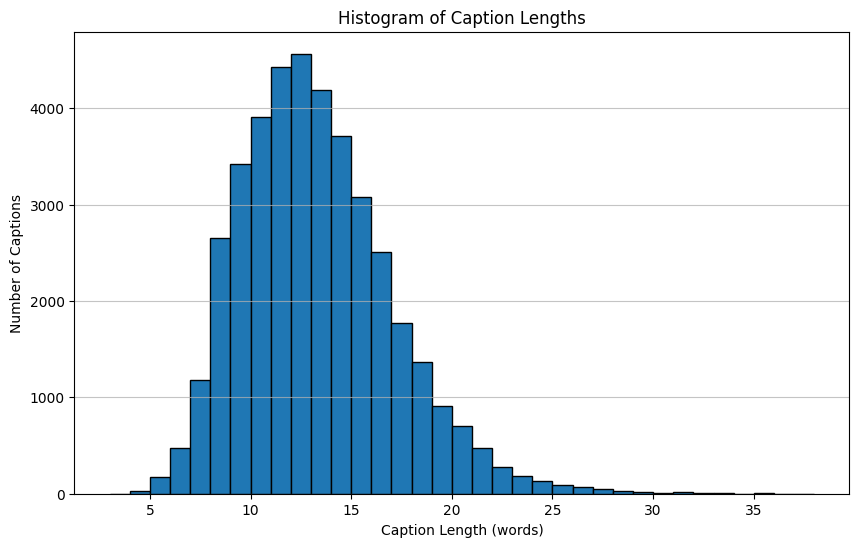

In [52]:
processor.plot_caption_length_histogram()

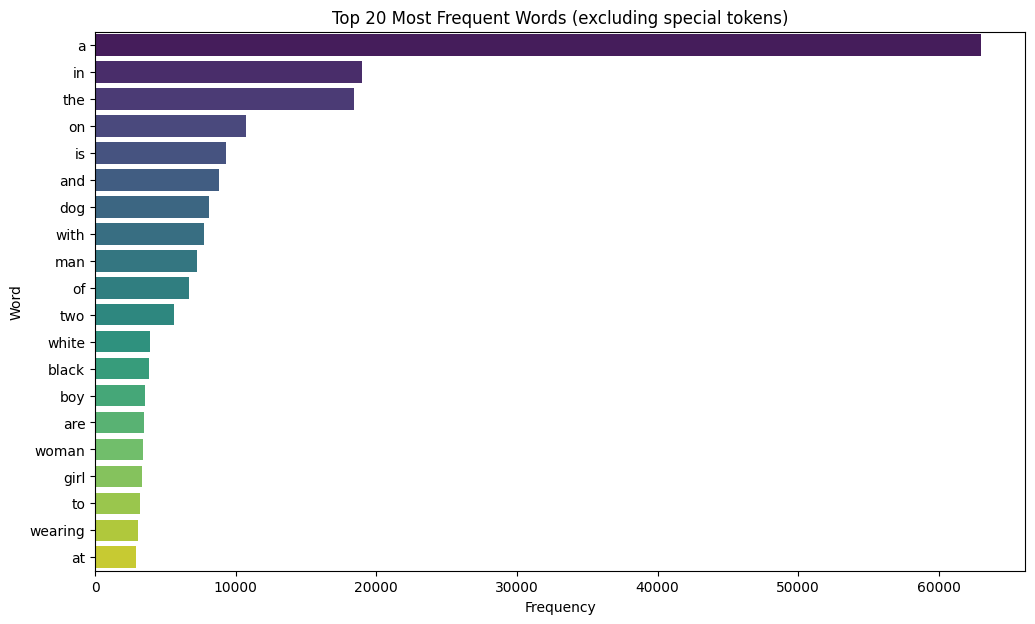

In [53]:
processor.plot_top_words(top_n=20)

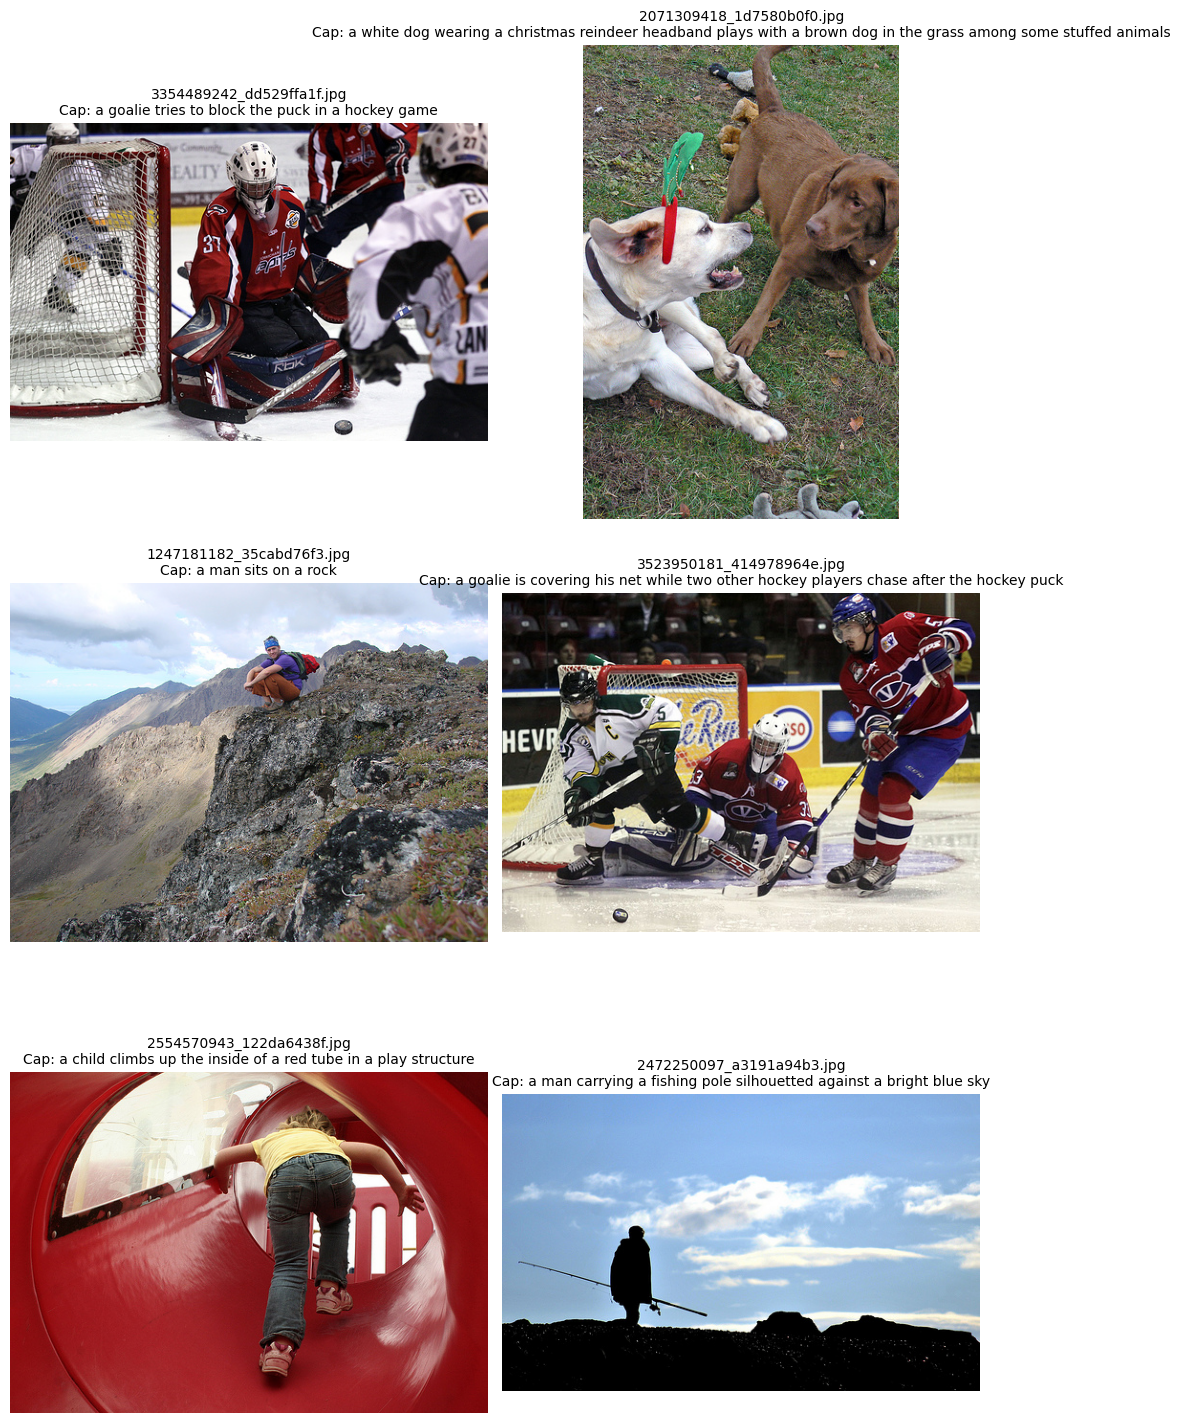

In [54]:
processor.plot_sample_images_with_caption(num_images=6)


#### Review of the built dataset


--- Displaying 2 Random Dataset Samples ---

--- Sample 1/2 ---
Image Name: 2419591925_1038c6c570.jpg


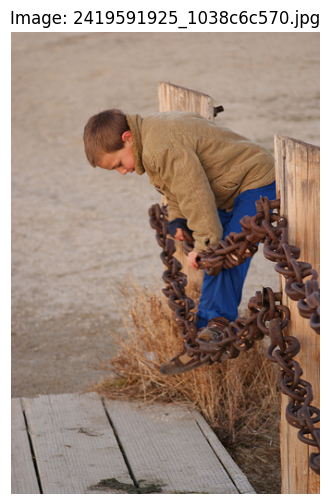

Ground Truth Captions:
  1. a boy in a brown jacket is standing on chains between two wooden posts
  2. a child standing on a heavy chain fence at a dock
  3. a little boy climbing over a chain fence
  4. a little boy standing and playing on a chained fence
  5. boy climbing on a chain fence

--- Sample 2/2 ---
Image Name: 2180480870_dcaf5ac0df.jpg


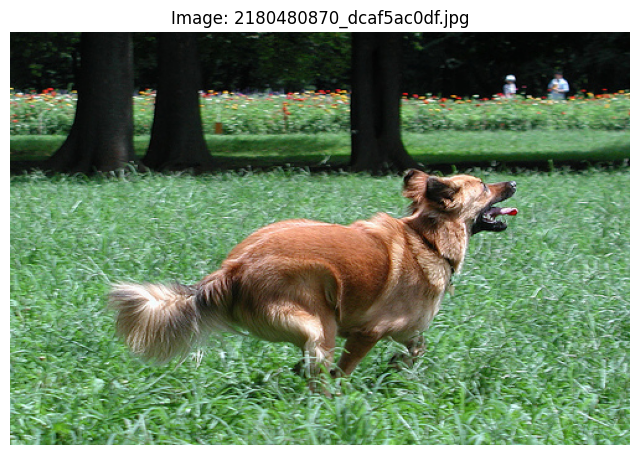

Ground Truth Captions:
  1. a brown dog is about to jump
  2. a dog runs through the grass
  3. a little brown dog running through a field of grass
  4. tan dog running through long grass in a parklike setting
  5. the large brownish dog is running through a grassy area


In [55]:
processor.display_samples(2)

#### Train, Val, Test split 

In [56]:
processor.create_dataset_splits(train_ratio=0.85, val_ratio=0.1)

Train images: 6877, Val images: 809, Test images: 405
Train pairs: 34385, Val pairs: 4045, Test pairs: 2025


#### Feature extractor

In [57]:
feature_extractor_model = ImageFeatureExtractor()

In [58]:
cache_manager = ImageFeatureCacheManager(CONFIG, feature_extractor_model)
image_name_to_cached_path_map = cache_manager.manage_feature_cache(processor.image_paths)
final_train_data, final_val_data, final_test_data = processor.get_data_with_cached_features(image_name_to_cached_path_map)


Managing image feature cache in: /home/flickr8k/cache
Checking/extracting features for 8091 unique images.
All image features already cached. Skipping extraction.
Image feature cache management complete.
Adjusted train pairs (after feature caching check): 34385
Adjusted val pairs (after feature caching check): 4045
Adjusted test pairs (after feature caching check): 2025


### CAPTIONING MODEL

In [59]:
trainer = ImageCaptioning(CONFIG, processor, feature_extractor_model)

Initializing from scratch.


In [60]:
trainer.summary()


--- Model Summaries ---

Encoder Model Summary:
Model: "encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            multiple                  196864    
                                                                 
Total params: 196,864
Trainable params: 196,864
Non-trainable params: 0
_________________________________________________________________

Decoder Model Summary:
Model: "decoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  765184    
                                                                 
 lstm_2 (LSTM)               multiple                  2099200   
                                                                 
 dense_13 (Dense)            multiple                  262656    
                         

### MODEL TRAINING

In [61]:
trainer.train(final_train_data, processor.val_data)

Resuming training from epoch 1.
Targeting a total of 30 epochs.

Epoch 1/30 (Scheduled Sampling Prob: 0.000)
Global Step 100 Batch 99 Loss 1.8150
Global Step 200 Batch 199 Loss 1.6694
Global Step 300 Batch 299 Loss 1.6243
Global Step 400 Batch 399 Loss 1.5475
Global Step 500 Batch 499 Loss 1.4936
Epoch 1 Loss 1.7006

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [00:50<00:00, 19.97it/s]


BLEU-1: 0.4937
BLEU-2: 0.2691
BLEU-3: 0.1391
BLEU-4: 0.0839
Training history and states saved.
Saving checkpoint at epoch 1 with BLEU-4: 0.0839
Time taken for 1 epoch: 136.06 secs

Epoch 2/30 (Scheduled Sampling Prob: 0.007)
Global Step 600 Batch 61 Loss 1.4980
Global Step 700 Batch 161 Loss 1.4084
Global Step 800 Batch 261 Loss 1.4423
Global Step 900 Batch 361 Loss 1.3344
Global Step 1000 Batch 461 Loss 1.4670
Epoch 2 Loss 1.4517

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:04<00:00, 15.60it/s]


BLEU-1: 0.5244
BLEU-2: 0.3025
BLEU-3: 0.1562
BLEU-4: 0.0874
Training history and states saved.
Saving checkpoint at epoch 2 with BLEU-4: 0.0874
Time taken for 1 epoch: 144.38 secs

Epoch 3/30 (Scheduled Sampling Prob: 0.014)
Global Step 1100 Batch 23 Loss 1.3957
Global Step 1200 Batch 123 Loss 1.3188
Global Step 1300 Batch 223 Loss 1.3282
Global Step 1400 Batch 323 Loss 1.2621
Global Step 1500 Batch 423 Loss 1.3283
Global Step 1600 Batch 523 Loss 1.3037
Epoch 3 Loss 1.3175

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:45<00:00,  6.06it/s]


BLEU-1: 0.1699
BLEU-2: 0.0934
BLEU-3: 0.0464
BLEU-4: 0.0232
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 246.51 secs

Epoch 4/30 (Scheduled Sampling Prob: 0.021)
Global Step 1700 Batch 85 Loss 1.3308
Global Step 1800 Batch 185 Loss 1.2279
Global Step 1900 Batch 285 Loss 1.2431
Global Step 2000 Batch 385 Loss 1.2007
Global Step 2100 Batch 485 Loss 1.2634
Epoch 4 Loss 1.2427

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


BLEU-1: 0.2562
BLEU-2: 0.1480
BLEU-3: 0.0778
BLEU-4: 0.0422
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 213.34 secs

Epoch 5/30 (Scheduled Sampling Prob: 0.028)
Global Step 2200 Batch 47 Loss 1.2363
Global Step 2300 Batch 147 Loss 1.3084
Global Step 2400 Batch 247 Loss 1.1662
Global Step 2500 Batch 347 Loss 1.1411
Global Step 2600 Batch 447 Loss 1.0871
Epoch 5 Loss 1.1931

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


BLEU-1: 0.4554
BLEU-2: 0.2761
BLEU-3: 0.1458
BLEU-4: 0.0811
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 176.61 secs

Epoch 6/30 (Scheduled Sampling Prob: 0.034)
Global Step 2700 Batch 9 Loss 1.1343
Global Step 2800 Batch 109 Loss 1.1631
Global Step 2900 Batch 209 Loss 1.0630
Global Step 3000 Batch 309 Loss 1.1088
Global Step 3100 Batch 409 Loss 1.1259
Global Step 3200 Batch 509 Loss 1.1226
Epoch 6 Loss 1.1549

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


BLEU-1: 0.4507
BLEU-2: 0.2812
BLEU-3: 0.1557
BLEU-4: 0.0875
Training history and states saved.
Saving checkpoint at epoch 6 with BLEU-4: 0.0875
Time taken for 1 epoch: 175.54 secs

Epoch 7/30 (Scheduled Sampling Prob: 0.041)
Global Step 3300 Batch 71 Loss 1.1806
Global Step 3400 Batch 171 Loss 1.1137
Global Step 3500 Batch 271 Loss 1.0657
Global Step 3600 Batch 371 Loss 1.1383
Global Step 3700 Batch 471 Loss 1.1261
Epoch 7 Loss 1.1225

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]


BLEU-1: 0.3694
BLEU-2: 0.2302
BLEU-3: 0.1282
BLEU-4: 0.0736
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 190.12 secs

Epoch 8/30 (Scheduled Sampling Prob: 0.048)
Global Step 3800 Batch 33 Loss 1.1046
Global Step 3900 Batch 133 Loss 1.1089
Global Step 4000 Batch 233 Loss 1.0689
Global Step 4100 Batch 333 Loss 1.1216
Global Step 4200 Batch 433 Loss 1.0872
Global Step 4300 Batch 533 Loss 1.1519
Epoch 8 Loss 1.0950

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]


BLEU-1: 0.4601
BLEU-2: 0.2906
BLEU-3: 0.1671
BLEU-4: 0.1004
Training history and states saved.
Saving checkpoint at epoch 8 with BLEU-4: 0.1004
Time taken for 1 epoch: 169.11 secs

Epoch 9/30 (Scheduled Sampling Prob: 0.055)
Global Step 4400 Batch 95 Loss 1.0750
Global Step 4500 Batch 195 Loss 1.1065
Global Step 4600 Batch 295 Loss 1.0886
Global Step 4700 Batch 395 Loss 1.1530
Global Step 4800 Batch 495 Loss 1.1653
Epoch 9 Loss 1.0703

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


BLEU-1: 0.4981
BLEU-2: 0.3201
BLEU-3: 0.1862
BLEU-4: 0.1086
Training history and states saved.
Saving checkpoint at epoch 9 with BLEU-4: 0.1086
Time taken for 1 epoch: 173.69 secs

Epoch 10/30 (Scheduled Sampling Prob: 0.062)
Global Step 4900 Batch 57 Loss 1.1028
Global Step 5000 Batch 157 Loss 1.0250
Global Step 5100 Batch 257 Loss 1.0144
Global Step 5200 Batch 357 Loss 1.0933
Global Step 5300 Batch 457 Loss 1.0668
Epoch 10 Loss 1.0498

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]


BLEU-1: 0.3795
BLEU-2: 0.2370
BLEU-3: 0.1388
BLEU-4: 0.0828
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 188.35 secs

Epoch 11/30 (Scheduled Sampling Prob: 0.069)
Global Step 5400 Batch 19 Loss 0.9172
Global Step 5500 Batch 119 Loss 0.9776
Global Step 5600 Batch 219 Loss 1.0146
Global Step 5700 Batch 319 Loss 1.1864
Global Step 5800 Batch 419 Loss 1.0640
Global Step 5900 Batch 519 Loss 1.0611
Epoch 11 Loss 1.0307

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:35<00:00, 10.47it/s]


BLEU-1: 0.4467
BLEU-2: 0.2909
BLEU-3: 0.1766
BLEU-4: 0.1086
Training history and states saved.
Saving checkpoint at epoch 11 with BLEU-4: 0.1086
Time taken for 1 epoch: 179.87 secs

Epoch 12/30 (Scheduled Sampling Prob: 0.076)
Global Step 6000 Batch 81 Loss 1.0449
Global Step 6100 Batch 181 Loss 1.0495
Global Step 6200 Batch 281 Loss 0.9144
Global Step 6300 Batch 381 Loss 1.0475
Global Step 6400 Batch 481 Loss 1.0851
Epoch 12 Loss 1.0136

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


BLEU-1: 0.4747
BLEU-2: 0.3087
BLEU-3: 0.1901
BLEU-4: 0.1187
Training history and states saved.
Saving checkpoint at epoch 12 with BLEU-4: 0.1187
Time taken for 1 epoch: 175.86 secs

Epoch 13/30 (Scheduled Sampling Prob: 0.083)
Global Step 6500 Batch 43 Loss 0.9479
Global Step 6600 Batch 143 Loss 1.0271
Global Step 6700 Batch 243 Loss 0.9736
Global Step 6800 Batch 343 Loss 1.0083
Global Step 6900 Batch 443 Loss 0.9158
Epoch 13 Loss 0.9982

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


BLEU-1: 0.4896
BLEU-2: 0.3248
BLEU-3: 0.2043
BLEU-4: 0.1308
Training history and states saved.
Saving checkpoint at epoch 13 with BLEU-4: 0.1308
Time taken for 1 epoch: 169.39 secs

Epoch 14/30 (Scheduled Sampling Prob: 0.090)
Global Step 7000 Batch 5 Loss 0.9315
Global Step 7100 Batch 105 Loss 1.0370
Global Step 7200 Batch 205 Loss 0.9762
Global Step 7300 Batch 305 Loss 0.9990
Global Step 7400 Batch 405 Loss 1.0342
Global Step 7500 Batch 505 Loss 1.0058
Epoch 14 Loss 0.9840

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.34it/s]


BLEU-1: 0.5514
BLEU-2: 0.3683
BLEU-3: 0.2321
BLEU-4: 0.1460
Training history and states saved.
Saving checkpoint at epoch 14 with BLEU-4: 0.1460
Time taken for 1 epoch: 164.78 secs

Epoch 15/30 (Scheduled Sampling Prob: 0.097)
Global Step 7600 Batch 67 Loss 0.8931
Global Step 7700 Batch 167 Loss 1.0077
Global Step 7800 Batch 267 Loss 0.9787
Global Step 7900 Batch 367 Loss 0.9656
Global Step 8000 Batch 467 Loss 1.0117
Epoch 15 Loss 0.9709

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


BLEU-1: 0.5175
BLEU-2: 0.3455
BLEU-3: 0.2157
BLEU-4: 0.1344
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 171.64 secs

Epoch 16/30 (Scheduled Sampling Prob: 0.103)
Global Step 8100 Batch 29 Loss 1.0001
Global Step 8200 Batch 129 Loss 1.0375
Global Step 8300 Batch 229 Loss 0.9797
Global Step 8400 Batch 329 Loss 0.8620
Global Step 8500 Batch 429 Loss 1.0483
Global Step 8600 Batch 529 Loss 0.9537
Epoch 16 Loss 0.9589

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.77it/s]


BLEU-1: 0.5439
BLEU-2: 0.3620
BLEU-3: 0.2336
BLEU-4: 0.1501
Training history and states saved.
Saving checkpoint at epoch 16 with BLEU-4: 0.1501
Time taken for 1 epoch: 167.95 secs

Epoch 17/30 (Scheduled Sampling Prob: 0.110)
Global Step 8700 Batch 91 Loss 1.0333
Global Step 8800 Batch 191 Loss 0.9187
Global Step 8900 Batch 291 Loss 0.9787
Global Step 9000 Batch 391 Loss 0.9294
Global Step 9100 Batch 491 Loss 0.8415
Epoch 17 Loss 0.9475

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


BLEU-1: 0.5737
BLEU-2: 0.3867
BLEU-3: 0.2511
BLEU-4: 0.1625
Training history and states saved.
Saving checkpoint at epoch 17 with BLEU-4: 0.1625
Time taken for 1 epoch: 165.66 secs

Epoch 18/30 (Scheduled Sampling Prob: 0.117)
Global Step 9200 Batch 53 Loss 1.0688
Global Step 9300 Batch 153 Loss 1.0083
Global Step 9400 Batch 253 Loss 0.8360
Global Step 9500 Batch 353 Loss 0.9629
Global Step 9600 Batch 453 Loss 0.9080
Epoch 18 Loss 0.9372

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.62it/s]


BLEU-1: 0.5136
BLEU-2: 0.3459
BLEU-3: 0.2218
BLEU-4: 0.1400
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 170.65 secs

Epoch 19/30 (Scheduled Sampling Prob: 0.124)
Global Step 9700 Batch 15 Loss 0.8600
Global Step 9800 Batch 115 Loss 0.9702
Global Step 9900 Batch 215 Loss 0.9603
Global Step 10000 Batch 315 Loss 0.8836
Global Step 10100 Batch 415 Loss 0.8862
Global Step 10200 Batch 515 Loss 0.9809
Epoch 19 Loss 0.9273

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


BLEU-1: 0.5584
BLEU-2: 0.3797
BLEU-3: 0.2494
BLEU-4: 0.1612
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 163.78 secs

Epoch 20/30 (Scheduled Sampling Prob: 0.131)
Global Step 10300 Batch 77 Loss 0.9327
Global Step 10400 Batch 177 Loss 0.9179
Global Step 10500 Batch 277 Loss 0.9278
Global Step 10600 Batch 377 Loss 0.8687
Global Step 10700 Batch 477 Loss 0.9386
Epoch 20 Loss 0.9176

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


BLEU-1: 0.5925
BLEU-2: 0.4066
BLEU-3: 0.2715
BLEU-4: 0.1803
Training history and states saved.
Saving checkpoint at epoch 20 with BLEU-4: 0.1803
Time taken for 1 epoch: 160.72 secs

Epoch 21/30 (Scheduled Sampling Prob: 0.138)
Global Step 10800 Batch 39 Loss 0.9997
Global Step 10900 Batch 139 Loss 0.9248
Global Step 11000 Batch 239 Loss 0.8675
Global Step 11100 Batch 339 Loss 0.8952
Global Step 11200 Batch 439 Loss 0.8443
Epoch 21 Loss 0.9090

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


BLEU-1: 0.5120
BLEU-2: 0.3502
BLEU-3: 0.2294
BLEU-4: 0.1508
BLEU-4 not improved. Patience counter: 1/8
Time taken for 1 epoch: 171.76 secs

Epoch 22/30 (Scheduled Sampling Prob: 0.145)
Global Step 11300 Batch 1 Loss 0.8409
Global Step 11400 Batch 101 Loss 0.8651
Global Step 11500 Batch 201 Loss 0.8902
Global Step 11600 Batch 301 Loss 0.8065
Global Step 11700 Batch 401 Loss 0.8546
Global Step 11800 Batch 501 Loss 0.9376
Epoch 22 Loss 0.9003

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:23<00:00, 11.97it/s]


BLEU-1: 0.5699
BLEU-2: 0.3871
BLEU-3: 0.2526
BLEU-4: 0.1638
BLEU-4 not improved. Patience counter: 2/8
Time taken for 1 epoch: 166.99 secs

Epoch 23/30 (Scheduled Sampling Prob: 0.152)
Global Step 11900 Batch 63 Loss 0.8555
Global Step 12000 Batch 163 Loss 0.8741
Global Step 12100 Batch 263 Loss 0.9318
Global Step 12200 Batch 363 Loss 0.9331
Global Step 12300 Batch 463 Loss 0.9171
Epoch 23 Loss 0.8922

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


BLEU-1: 0.5689
BLEU-2: 0.3917
BLEU-3: 0.2572
BLEU-4: 0.1664
BLEU-4 not improved. Patience counter: 3/8
Time taken for 1 epoch: 165.72 secs

Epoch 24/30 (Scheduled Sampling Prob: 0.159)
Global Step 12400 Batch 25 Loss 0.8510
Global Step 12500 Batch 125 Loss 0.8204
Global Step 12600 Batch 225 Loss 0.9022
Global Step 12700 Batch 325 Loss 0.9622
Global Step 12800 Batch 425 Loss 0.9110
Global Step 12900 Batch 525 Loss 0.9270
Epoch 24 Loss 0.8845

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


BLEU-1: 0.5837
BLEU-2: 0.3989
BLEU-3: 0.2621
BLEU-4: 0.1701
BLEU-4 not improved. Patience counter: 4/8
Time taken for 1 epoch: 162.59 secs

Epoch 25/30 (Scheduled Sampling Prob: 0.166)
Global Step 13000 Batch 87 Loss 0.8454
Global Step 13100 Batch 187 Loss 0.8141
Global Step 13200 Batch 287 Loss 0.8965
Global Step 13300 Batch 387 Loss 0.8158
Global Step 13400 Batch 487 Loss 0.9007
Epoch 25 Loss 0.8768

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s]


BLEU-1: 0.5680
BLEU-2: 0.3940
BLEU-3: 0.2605
BLEU-4: 0.1728
BLEU-4 not improved. Patience counter: 5/8
Time taken for 1 epoch: 166.77 secs

Epoch 26/30 (Scheduled Sampling Prob: 0.172)
Global Step 13500 Batch 49 Loss 0.9452
Global Step 13600 Batch 149 Loss 0.9355
Global Step 13700 Batch 249 Loss 0.9146
Global Step 13800 Batch 349 Loss 0.8268
Global Step 13900 Batch 449 Loss 0.8601
Epoch 26 Loss 0.8694

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.36it/s]


BLEU-1: 0.5780
BLEU-2: 0.4028
BLEU-3: 0.2683
BLEU-4: 0.1778
BLEU-4 not improved. Patience counter: 6/8
Time taken for 1 epoch: 165.19 secs

Epoch 27/30 (Scheduled Sampling Prob: 0.179)
Global Step 14000 Batch 11 Loss 0.8159
Global Step 14100 Batch 111 Loss 0.8581
Global Step 14200 Batch 211 Loss 0.8604
Global Step 14300 Batch 311 Loss 0.8157
Global Step 14400 Batch 411 Loss 0.9571
Global Step 14500 Batch 511 Loss 0.8659
Epoch 27 Loss 0.8625

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:22<00:00, 12.11it/s]


BLEU-1: 0.5820
BLEU-2: 0.4018
BLEU-3: 0.2670
BLEU-4: 0.1748
BLEU-4 not improved. Patience counter: 7/8
Time taken for 1 epoch: 167.04 secs

Epoch 28/30 (Scheduled Sampling Prob: 0.186)
Global Step 14600 Batch 73 Loss 0.8363
Global Step 14700 Batch 173 Loss 0.8205
Global Step 14800 Batch 273 Loss 0.8004
Global Step 14900 Batch 373 Loss 0.8416
Global Step 15000 Batch 473 Loss 0.7991
Epoch 28 Loss 0.8557

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:26<00:00, 11.60it/s]


BLEU-1: 0.5557
BLEU-2: 0.3799
BLEU-3: 0.2476
BLEU-4: 0.1596
BLEU-4 not improved. Patience counter: 8/8
Early stopping triggered at epoch 28.


#### Additional training runs

In [62]:
CONFIG['epochs'] = 40
trainer.train(final_train_data, processor.val_data)

Resuming training from epoch 29.
Targeting a total of 40 epochs.

Epoch 29/40 (Scheduled Sampling Prob: 0.144)
Global Step 15100 Batch 35 Loss 0.8996
Global Step 15200 Batch 135 Loss 0.7948
Global Step 15300 Batch 235 Loss 0.8504
Global Step 15400 Batch 335 Loss 0.8569
Global Step 15500 Batch 435 Loss 0.8629
Global Step 15600 Batch 535 Loss 0.7462
Epoch 29 Loss 0.8489

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.46it/s]


BLEU-1: 0.5819
BLEU-2: 0.3993
BLEU-3: 0.2656
BLEU-4: 0.1769
BLEU-4 not improved. Patience counter: 9/8
Early stopping triggered at epoch 29.


In [63]:
CONFIG['epochs'] = 50
trainer.train(final_train_data, processor.val_data)

Resuming training from epoch 30.
Targeting a total of 50 epochs.

Epoch 30/50 (Scheduled Sampling Prob: 0.118)
Global Step 15700 Batch 97 Loss 0.9327
Global Step 15800 Batch 197 Loss 0.8187
Global Step 15900 Batch 297 Loss 0.8121
Global Step 16000 Batch 397 Loss 0.8386
Global Step 16100 Batch 497 Loss 0.8356
Epoch 30 Loss 0.8426

Evaluating BLEU on 1000 samples...


100%|██████████| 1000/1000 [01:24<00:00, 11.82it/s]


BLEU-1: 0.5586
BLEU-2: 0.3847
BLEU-3: 0.2563
BLEU-4: 0.1683
BLEU-4 not improved. Patience counter: 10/8
Early stopping triggered at epoch 30.


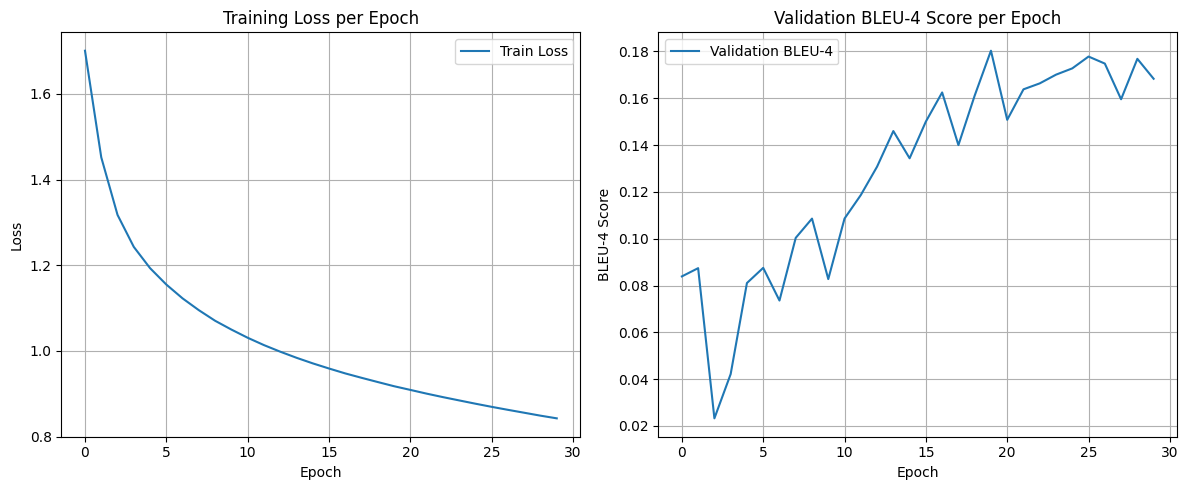

In [64]:
trainer.plot_history()

### MODEL EVALUATION

In [69]:
model = ImageCaptioning(CONFIG, processor, feature_extractor_model)

Restored from ./checkpoints/flickr8k_fresh_run/ckpt-12
Training history and states loaded.


In [70]:
model.evaluate_bleu_score(processor.test_data)


Evaluating BLEU on 2025 samples...


  0%|          | 0/2025 [00:00<?, ?it/s]

100%|██████████| 2025/2025 [02:37<00:00, 12.86it/s]


BLEU-1: 0.5765
BLEU-2: 0.3992
BLEU-3: 0.2642
BLEU-4: 0.1768


{'bleu-1': 0.5765124555160143,
 'bleu-2': 0.3991683005873538,
 'bleu-3': 0.26417825382752536,
 'bleu-4': 0.17680386976607598}

In [71]:
model.run_prediction_samples(processor.test_data, num_samples=10)


--- Running Predictions for 10 Random Samples ---

--- Prediction Sample 1/10 (Image: 2474918824_88660c7757.jpg) ---
Ground Truth Captions:
  1. a guy tries to climb a stone cliff while his friend helps him
  2. a man in a red shirt climbs a rock while another man stands behind to help him
  3. a man in a red shirt is learning how to climb a cliff
  4. a man in brown is helping a man in red climb a rock
  5. a man wearing a brown sweatshirt helps a man in red climb a rock
Generated Caption (Beam Search): a man in a white shirt is jumping over a rock wall
Prediction Time: 444.10 ms

--- Prediction Sample 2/10 (Image: 3048597471_5697538daf.jpg) ---
Ground Truth Captions:
  1. a brown dog is swimming through water with an orange ball in its mouth
  2. a dark brow dog holds an orange ball in his mouth while walking through water
  3. a dog wading in the water with a ball in his mouth
  4. a wet brownishred dog with an orange ball in his mouth is swimming in some water
  5. brown dog in wa

### SHOW AND TELL DEMO

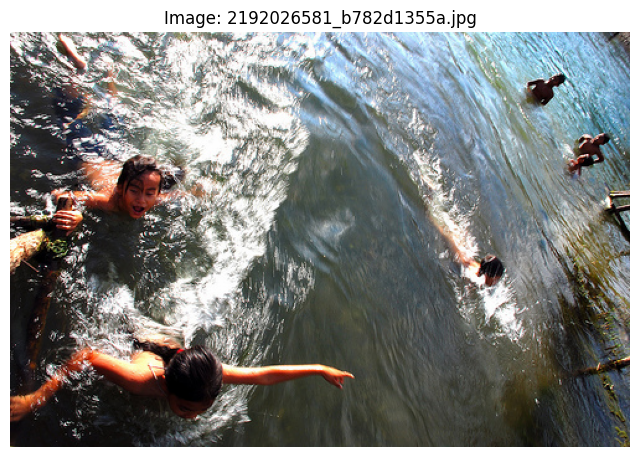


Ground Truth Captions:
  1. a bunch of people swimming in water
  2. a group of children in the ocean
  3. a group of youngsters swim in lake water
  4. many children are playing and swimming in the water
  5. several people swim in a body of water

Generated Caption (Beam Search): a man sits on a cliff

Playing generated caption:


Audio saved to caption_audio_2192026581_b782d1355a.mp3 and played.


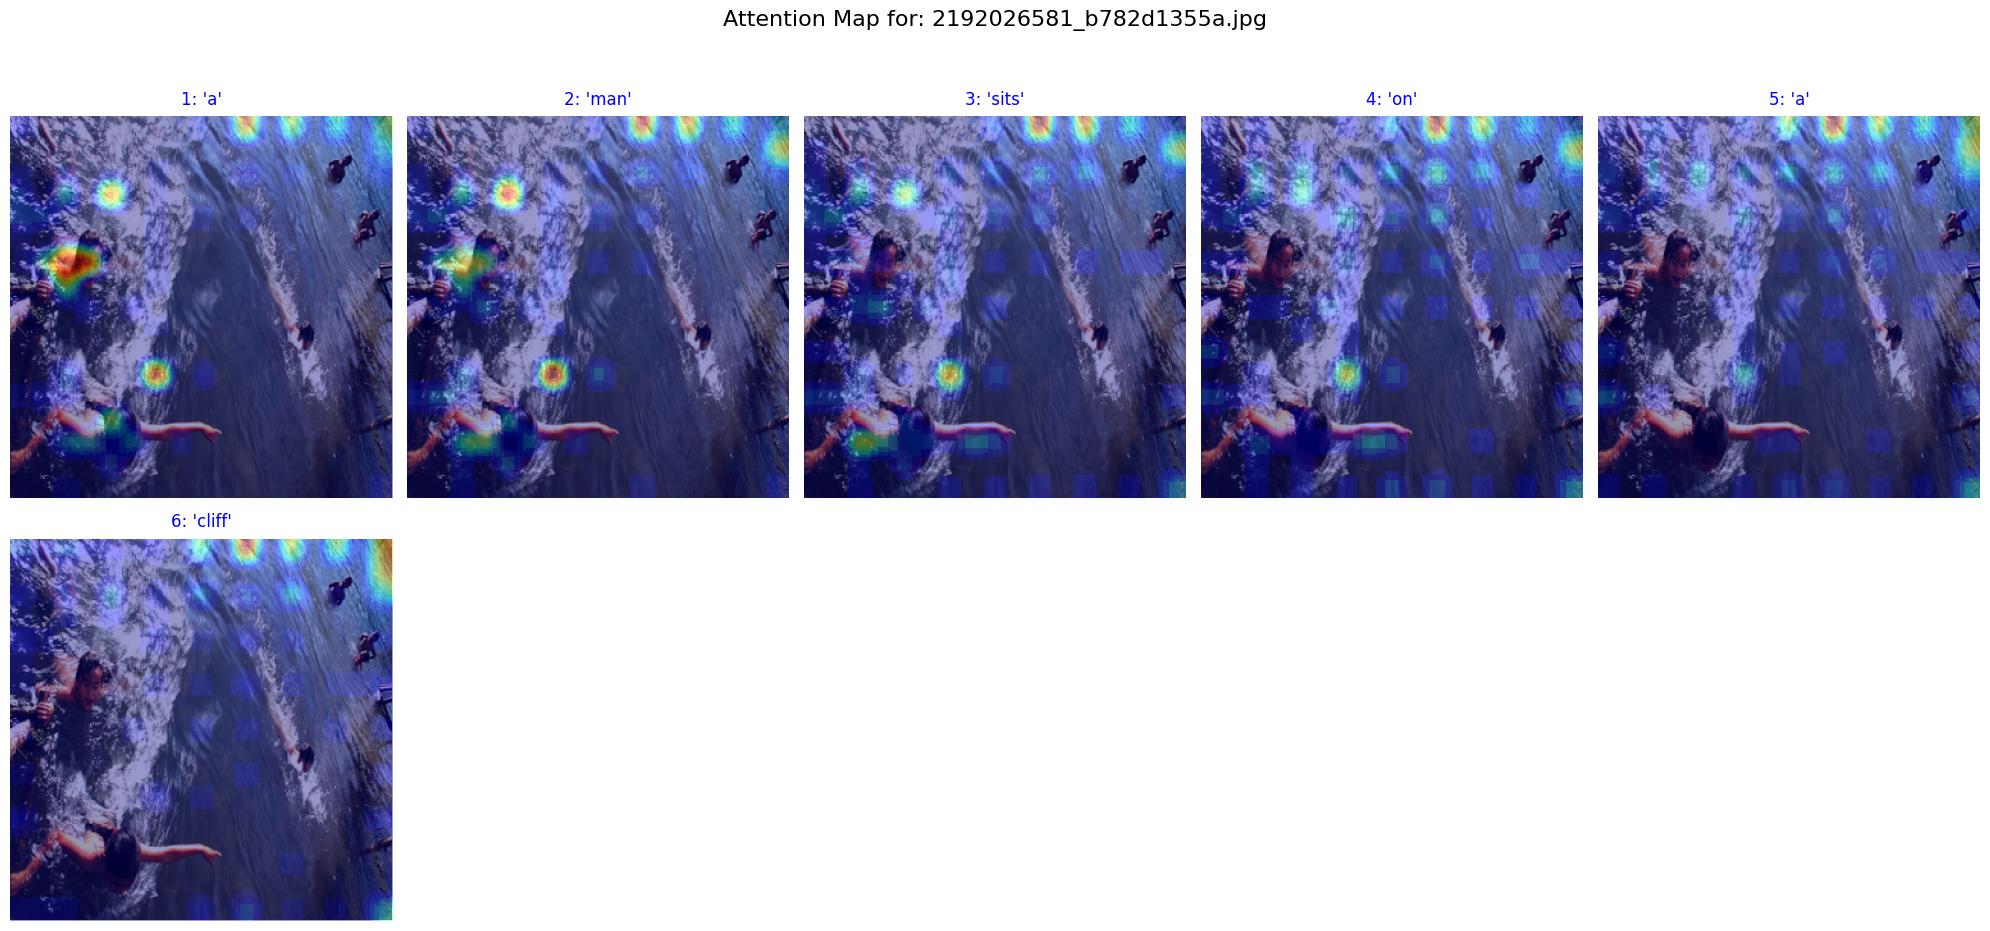

In [72]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    model.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

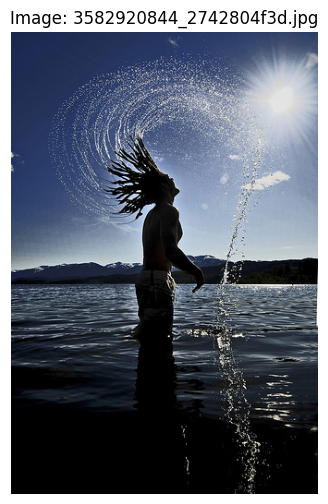


Ground Truth Captions:
  1. a long haired mail is swinging his wet hair around in the ocean
  2. a long haired man in the water is swinging his head causing the water to spray in a spiral
  3. a man wading in a lake dips his long hair into the water and quickly throws his head back making a brief rainbow of water overhear
  4. a person in the water
  5. a woman flips her hair full of water and sprays the water all around

Generated Caption (Beam Search): a man in a blue shirt is jumping into the water

Playing generated caption:


Audio saved to caption_audio_3582920844_2742804f3d.mp3 and played.


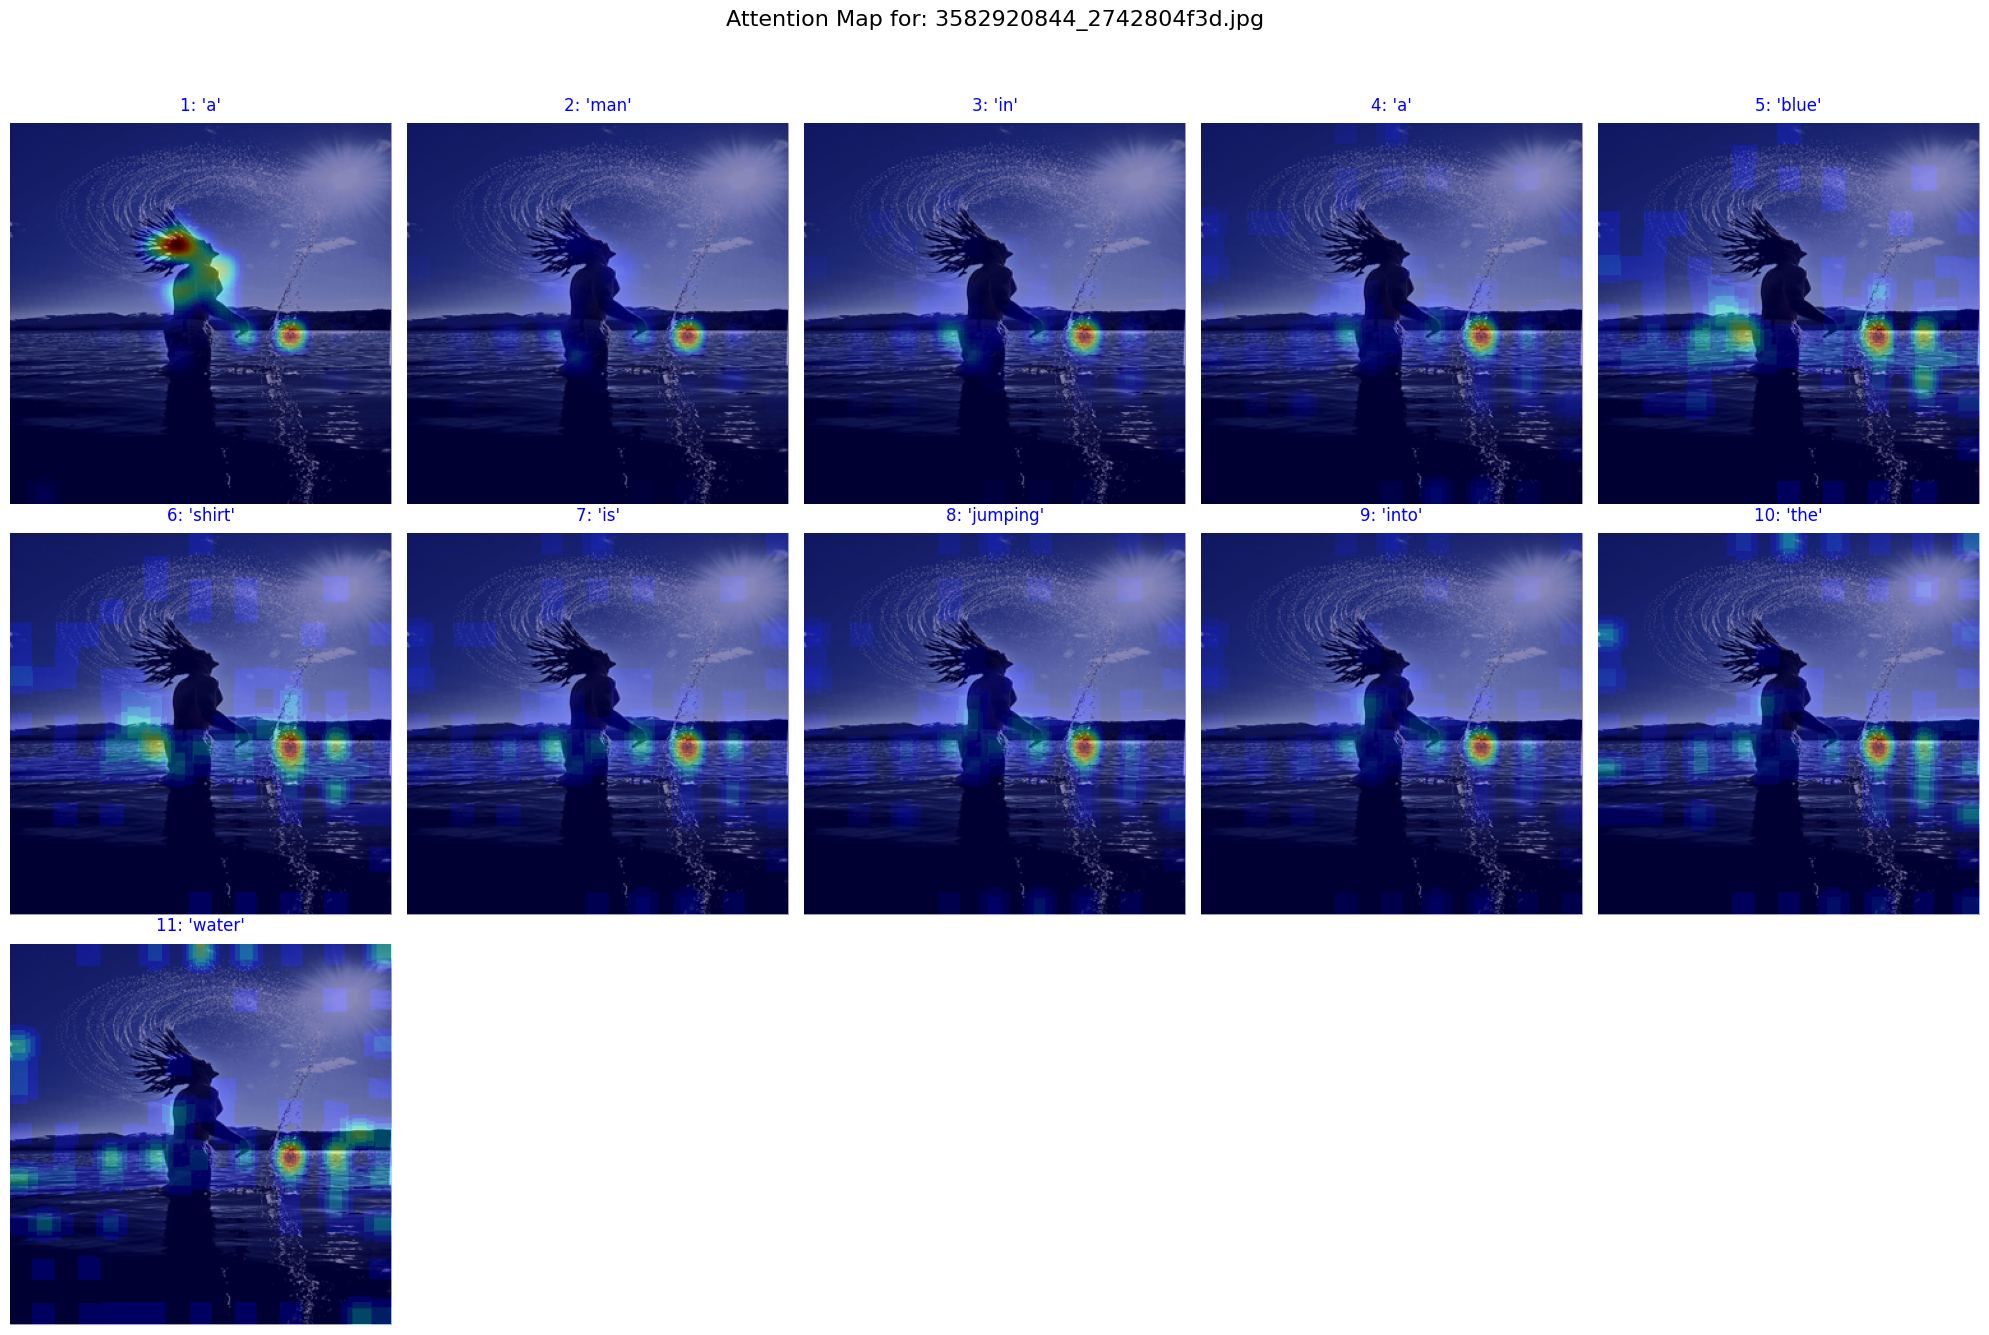

In [73]:
if processor.test_data:
    random_test_img_path, _ = random.choice(processor.test_data)
    model.demo(os.path.basename(random_test_img_path))
else:
    print("No test data available for demo.")

### Comparision with other notable work with Flickr-8k

| Model / Paper (Flickr-8k test split) | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 |
|-------------------------------------|:------:|:------:|:------:|:------:|
| **My best checkpoint (Attn)**      | ▢      | ▢      | ▢      | ▢      |
| Xu et al., 2015 — *Soft-Attention*  | 0.67 | 0.448 | 0.299 | 0.195  |
| Xu et al., 2015 — *Hard-Attention*  | 0.67 | 0.457 | 0.314 | 0.213  |
| Google NIC (Vinyals et al., 2015)   | 0.63 | 0.41  | 0.27  | 0.160* |

* BLEU-4 for NIC comes from a later re-implementation that reports full n-gram scores on the official Flickr-8k split.


[^1]: Kelvin Xu, Jimmy Lei Ba, Ryan Kiros, Kyunghyun Cho, Aaron Courville,  
      Ruslan Salakhutdinov, Richard Zemel & Yoshua Bengio.  
      *Show, Attend and Tell: Neural Image Caption Generation with Visual Attention*.  
      Proceedings of the 32nd International Conference on Machine Learning (ICML 2015),  
      PMLR 37, pp. 2048–2057. :contentReference[oaicite:0]{index=0}

[^2]: Oriol Vinyals, Alexander Toshev, Samy Bengio & Dumitru Erhan.  
      *Show and Tell: A Neural Image Caption Generator*.  
      Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR 2015),  
      pp. 3156–3164. DOI 10.1109/CVPR.2015.7298935. :contentReference[oaicite:1]{index=1}
